# Finance Sentiment Analysis Project

- Predicting stock prices using data from reddit on the r/wallstreetbets subreddit
- Data courtesy of Gabriel Preda on Kaggle

Stock prices at the lowest level, are reflections of investors thoughts on if a company has the potential to grow or not. I wanted to investigate the potential relationship between investor sentiment on reddit and the price of a stock.

- [x] Load Reddit Datset
- [x] Conduct intial EDA on the reddit dataset
- [x] Using VADER, conduct sentiment analysis on the reddit dataset


In [143]:
!which python

/opt/anaconda3/bin/python


In [144]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from wordcloud import WordCloud
from datetime import date
import string

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gakuueno/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gakuueno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/gakuueno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/gakuueno/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/gakuueno/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Loading in the Dataset

In [145]:
reddit_data = pd.read_csv('../data/reddit_wsb.csv')
reddit_data.head(5)

title  score      id  \
0  It's not about the money, it's about sending a...     55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                    Exit the system      0  l6uhhn   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4  Not to distract from GME, just thought our AMC...     71  l6ufgy   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
3  https://sec.report/Document/0001193125-21-019848/         74  1.611862e+09   
4                https://i.redd.it/4h2sukb662e61.jpg        156  1.611862e+09   

                                                body            timestamp  
0                                                NaN  2021-01-28 21:37:41  
1                                                NaN  2021-01-28 21:32:10  
2  The CEO of NASDAQ pushed to halt trading “to g...  2021-01-28 21:30:35  
3                                                NaN  2021-01-28 21:28:57  
4                                                NaN  2021-01-28 21:26:56

# EDA and getting to know the dataset

In [146]:
print(reddit_data.columns)
print(reddit_data.shape)
print(reddit_data.dtypes)
print(reddit_data.describe())

Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'timestamp'],
      dtype='object')
(53187, 8)
title         object
score          int64
id            object
url           object
comms_num      int64
created      float64
body          object
timestamp     object
dtype: object
               score     comms_num       created
count   53187.000000  53187.000000  5.318700e+04
mean     1382.461053    263.260252  1.614582e+09
std      7999.271074   2532.665113  4.173566e+06
min         0.000000      0.000000  1.601340e+09
25%         2.000000      3.000000  1.611882e+09
50%        37.000000     17.000000  1.612488e+09
75%       207.000000     60.000000  1.615347e+09
max    348241.000000  93268.000000  1.629095e+09


In [147]:
# Distribution of post lengths

reddit_data['post_length'] = reddit_data['title'].apply(lambda post: len(post))
post_len_dist = px.histogram(reddit_data, x = 'post_length', nbins = 10)
post_len_dist.update_layout(template="plotly_dark")
post_len_dist.show()

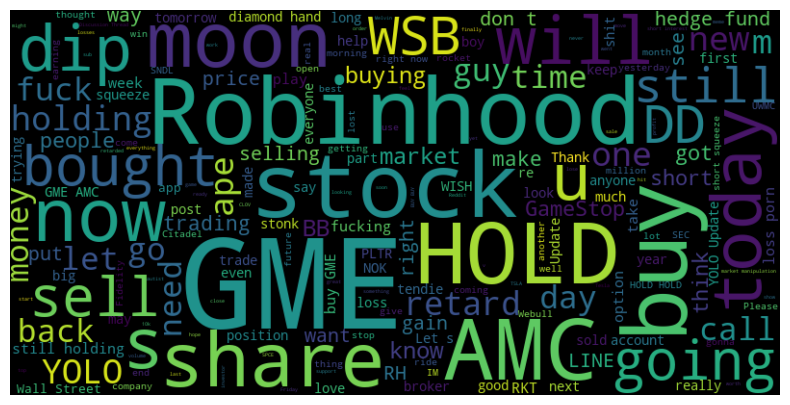

In [148]:
#Most commonly mentioned words in the data

posts = ' '.join(reddit_data['title'].values)

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(posts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [149]:
reddit_data['timestamp'] = pd.to_datetime(reddit_data['timestamp']).apply(lambda timestamp: timestamp.date())

dates = px.scatter(reddit_data, x = 'timestamp', y = [1] * reddit_data.shape[0])
dates.update_layout(template="plotly_dark")
dates.show()


In [150]:
reddit_data = reddit_data.sort_values(by = 'timestamp', ascending = True).loc[1:].reset_index(drop = True)

In [151]:
date_post_count_data = reddit_data.groupby('timestamp').count().reset_index()

date_post_count_plot = px.scatter(date_post_count_data, x = 'timestamp', y = 'title')
date_post_count_plot.add_scatter(x=date_post_count_data['timestamp'], y=date_post_count_data['title'], mode='lines', name='Line')
date_post_count_plot.update_layout(template="plotly_dark")
date_post_count_plot.show()

## Why was there a spike in post counts in January 29, 2021?

January 29th 2021 aligns with the date individual investors bought on mass gamestop stock. Since the movement initally began on the subreddit thread wallstreetbets, this explains the spike in posts that day.

In [152]:
#Checking if any of the posts have any nan values
reddit_data['title'].isna().sum()

0

In [153]:
#combining title and post into one text column

reddit_data['body'].fillna("", inplace = True)
reddit_data['text'] = reddit_data['title'] + " " + reddit_data['body']

# Sentiment Analysis
## Data Preprocessing

In [154]:
#combining title and post into one text column

reddit_data['body'].fillna("", inplace = True)
reddit_data['text'] = reddit_data['title'] + " " + reddit_data['body']

In [155]:
sia = SentimentIntensityAnalyzer()
reddit_data['sentiment_score'] = reddit_data['text'].apply(lambda text: sia.polarity_scores(text)['compound'])
reddit_data.head(5)

title  score      id  \
0  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
1                                   Robinhood update      5  l6wz44   
2                       420 wasn’t a meme. GME 🚀 🚀 🚀    240  l6u8gs   
3                           Before you sleep tonight    550  l6s3d9   
4                        To The Mass Relays & Beyond    107  l6u5j2   

                                                 url  comms_num       created  \
0                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
1  https://www.reddit.com/r/wallstreetbets/commen...          2  1.611870e+09   
2                https://i.redd.it/7z279wtz32e61.jpg         49  1.611861e+09   
3  https://www.reddit.com/r/wallstreetbets/commen...        147  1.611853e+09   
4                       https://youtu.be/UXLVFnl3WcE         14  1.611861e+09   

                                                body   timestamp  post_length  \
0                                                     2021-01-28           80   
1  Do you think Robin Hood is trying to manipulat...  2021-01-28           16   
2                                                     2021-01-28           28   
3  Just think about this in simple terms. Everyon...  2021-01-28           24   
4                                                     2021-01-28           27   

                                                text  sentiment_score  
0  Math Professor Scott Steiner says the numbers ...          -0.7034  
1  Robinhood update Do you think Robin Hood is tr...           0.0000  
2                      420 wasn’t a meme. GME 🚀 🚀 🚀            0.0000  
3  Before you sleep tonight Just think about this...           0.7685  
4                       To The Mass Relays & Beyond            0.0000

In [156]:
print(reddit_data['sentiment_score'].describe())

count    52386.000000
mean         0.154606
std          0.550879
min         -0.999900
25%         -0.128000
50%          0.000000
75%          0.624900
max          1.000000
Name: sentiment_score, dtype: float64


In [157]:
seniment_box = px.box(reddit_data, x = 'sentiment_score')
seniment_box.update_layout(template='plotly_dark')

In [158]:
sentiment_dist = px.histogram(reddit_data, x = 'sentiment_score', nbins = 10)
sentiment_dist.update_layout(template='plotly_dark')

In [159]:
# Divide the dataset into positives and negatives to see what sort of differences are there between them
pos_sentiment = reddit_data[reddit_data['sentiment_score'] > 0.25]
neg_sentiment = reddit_data[reddit_data['sentiment_score'] < -0.25]


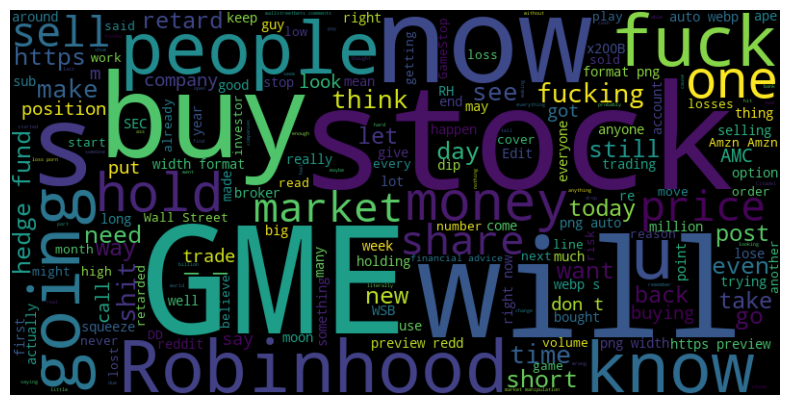

In [172]:
#Most commonly mentioned words in posts with positive sentiment
posts = ' '.join(pos_sentiment['text'].values)

pos_sent_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(posts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

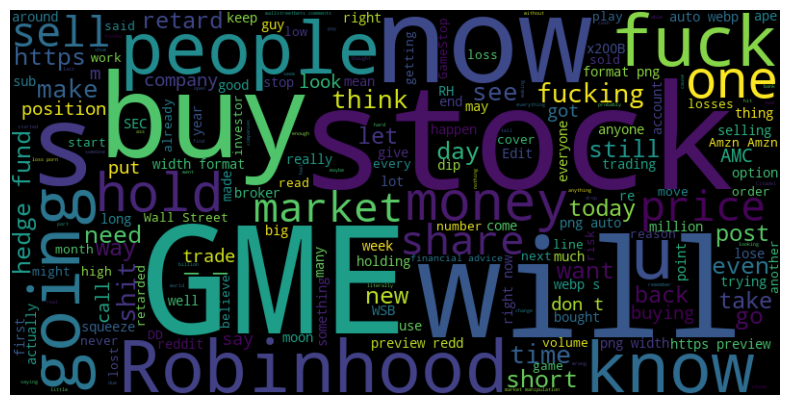

In [171]:
#Most commonly mentioned words in posts with negative sentiment
posts = ' '.join(neg_sentiment['text'].values)

neg_sent_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(posts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Giving a glance at the words, it does not seem like there is a lot in common between posts with postive and negative sentiment.

In [167]:
# Change in sentiment over time
day_agg = reddit_data.groupby('timestamp').mean(numeric_only =True).reset_index()
day_agg

timestamp        score   comms_num       created  post_length  \
0    2021-01-28   687.659950  221.788413  1.611865e+09    57.617128   
1    2021-01-29   408.457309   52.371288  1.611882e+09    54.970817   
2    2021-01-30  4618.594101  515.766152  1.611983e+09    66.883427   
3    2021-01-31  5230.513312  306.713525  1.612077e+09    69.379127   
4    2021-02-01  4230.302036  531.211538  1.612171e+09    71.330317   
..          ...          ...         ...           ...          ...   
171  2021-08-12   647.386667  481.200000  1.628768e+09    49.453333   
172  2021-08-13   773.593750  695.546875  1.628848e+09    46.937500   
173  2021-08-14  1204.837838  153.783784  1.628921e+09    52.972973   
174  2021-08-15  1210.619048  630.666667  1.629033e+09    49.761905   
175  2021-08-16    66.090909   28.272727  1.629086e+09    51.818182   

     sentiment_score  
0          -0.024413  
1          -0.008826  
2           0.152962  
3           0.163455  
4           0.169128  
..               ...  
171         0.377009  
172         0.295266  
173         0.275024  
174         0.628829  
175         0.717727  

[176 rows x 6 columns]

In [177]:
avg_scores_overtime = px.scatter(day_agg, x = 'timestamp', y = 'sentiment_score')

avg_scores_overtime.update_layout(template="plotly_dark")
avg_scores_overtime.show()